In [18]:
import pandas as pd
import numpy as np 
import sqlite3 as sql
import seaborn as sns
import matplotlib.pylab as plt
import json 
import ast
import warnings
warnings.filterwarnings("ignore")

In [45]:
# Reading in data and creating database file
df_athletes = pd.read_csv('data/Athlete Search Test - sheet1.csv')
conn = sql.connect('athleteSearch.db')
df_athletes['date'] = pd.to_datetime(df_athletes['date'])

In [108]:
# Creating SQL table 
df_athletes.to_sql('athletes', conn)

ValueError: Table 'athletes' already exists.

In [20]:
query = 'SELECT * FROM athletes'
new_df = pd.read_sql(query, conn)
new_df.head(1)

,index,search_id,date,brand_userID,brand_profileID,planLevel,minPrice,maxPrice,view_id,user,path,entity,view_created,athlete_userID,athlete_profileID,athlete_name_y
0,0,6324bdc92868650d6a287230,2022-09-16 18:17:45,6324bc99ae320d0d70685b40,6324bc9aefe46f0d71d8e376,3,100.0,500.0,None,None,None,None,None,None,None,None
1,1,63249faddc535e0d52662a36,2022-09-16 16:09:17,63249f32dc535e0d526621fb,63249f32dc535e0d52662213,3,NaN,300.0,None,None,None,None,None,None,None,None
2,2,632426c9a6dd320d8fa0c863,2022-09-16 07:33:30,6265b7fc658e4b0d9db1ad1a,6265b7fd7e6fce7d64a970d9,3,NaN,500.0,None,None,None,None,None,None,None,None
3,3,632426c8a6dd320d8fa0c848,2022-09-16 07:33:28,6265b7fc658e4b0d9db1ad1a,6265b7fd7e6fce7d64a970d9,3,NaN,500.0,None,None,None,None,None,None,None,None
4,4,632426c5a6dd320d8fa0c801,2022-09-16 07:33:26,6265b7fc658e4b0d9db1ad1a,6265b7fd7e6fce7d64a970d9,3,100.0,500.0,None,None,None,None,None,None,None,None


## What trends do you see for plan level 0, plan level 3 and plan level 9?

### average number of searches per hour each day - Searches for plan level 0 peak at 3pm whereas searches for plan level 3 peak at 7pm

In [31]:
query = '''SELECT 
                planLevel,
                CAST(strftime('%H', date) AS INTEGER) AS hour,
                COUNT(search_id) AS searchCount
           FROM athletes
           WHERE date IS NOT NULL AND date <> 'NaN'
           GROUP BY STRFTIME('%H', date), planLevel
        '''
searches_hr_df = pd.read_sql(query, conn)
searches_hr_df.head(5)

,planLevel,hour,searchCount
0,0,0,167
1,3,0,31
2,0,1,169
3,3,1,15
4,0,2,209


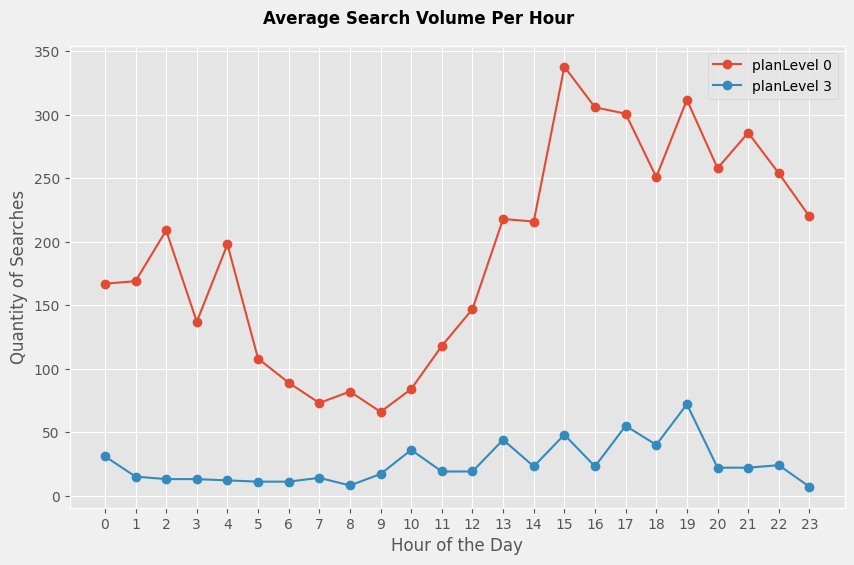

In [32]:
# Using ggplot for quick styling 
plt.style.use('ggplot')


fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor("#F0F0F0")

# Selecting data for each plan level 
planLevel_3 = searches_hr_df[searches_hr_df['planLevel'] == 3]
planLevel_0 = searches_hr_df[searches_hr_df['planLevel'] == 0]

# Plotting the lines for each plan level 
plt.plot(planLevel_0['hour'], planLevel_0['searchCount'], label='planLevel 0', marker='o')
plt.plot(planLevel_3['hour'], planLevel_3['searchCount'], label='planLevel 3', marker='o')

plt.title('Average Search Volume Per Hour', 
             fontsize = 12, fontweight = 'bold', x= .45, y = 1.03)



ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Quantity of Searches')
plt.xticks(range(0, 24))
plt.legend()


plt.show()

### Max price by month and plan level - As we can see the average max price for plan level 0 users hit a high of approximately $11500. The average minimum price stayed pretty consistent throughout the year.

In [43]:
query = '''SELECT STRFTIME('%Y-%m', date) AS month,
                planLevel,
                AVG(maxPrice) AS maxPrice,
                AVG(minPrice) AS minPrice
           FROM athletes
           WHERE date IS NOT NULL AND date <> 'NaN'
           GROUP BY STRFTIME('%Y-%m', date), planLevel
        '''
pl_month_df = pd.read_sql(query, conn)
pl_month_df.head(50)

,month,planLevel,maxPrice,minPrice
0,2022-01,0,3258.250620,690.048319
1,2022-02,0,3195.467914,1645.108365
2,2022-03,0,4479.190840,1528.592025
3,2022-04,0,4644.426923,1307.140351
4,2022-05,0,8310.849673,359.131673
5,2022-06,0,11202.191837,359.714789
6,2022-07,0,11506.380180,1259.276836
7,2022-08,0,1357.976654,686.705556
8,2022-08,3,2600.352113,6475.875000
9,2022-09,3,2287.312030,1110.808511


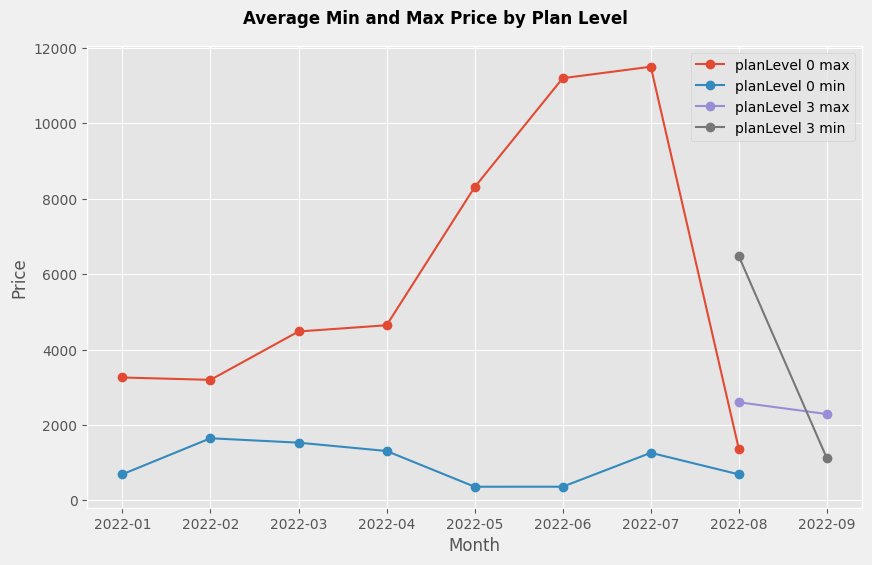

In [46]:
plt.style.use('ggplot')


fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor("#F0F0F0")

# Plotting the first 8 rows for plan level 0
plt.plot(pl_month_df['month'][0:8], pl_month_df['maxPrice'][0:8], marker='o', linestyle='-')
plt.plot(pl_month_df['month'][0:8], pl_month_df['minPrice'][0:8], marker='o', linestyle='-')

# PLotting the last 2 rows for plan level 3
plt.plot(pl_month_df['month'][8:], pl_month_df['maxPrice'][8:], marker='o', linestyle='-')
plt.plot(pl_month_df['month'][8:], pl_month_df['minPrice'][8:], marker='o', linestyle='-')

plt.title('Average Min and Max Price by Plan Level', 
             fontsize = 12, fontweight = 'bold', x= .45, y = 1.03)

plt.legend(labels = ['planLevel 0 max', 'planLevel 0 min', 'planLevel 3 max', 'planLevel 3 min'])

ax.set_xlabel('Month')
ax.set_ylabel('Price')
# plt.xticks(range(0, 24))


plt.show()

### Search volume per month - The search volume saw a steady decline throughout 2022 for both plan levels. In january the search volume was at its yearly high, but the average price was at a yearly low. 

In [35]:
query = '''SELECT STRFTIME('%Y-%m', date) AS month,
                planLevel,
                COUNT(search_id) AS searchCount
           FROM athletes
           WHERE date IS NOT NULL AND date <> 'NaN'
           GROUP BY STRFTIME('%Y-%m', date), planLevel
        '''
pl_month_df = pd.read_sql(query, conn)
pl_month_df.head(50)

,month,planLevel,searchCount
0,2022-01,0,852
1,2022-02,0,802
2,2022-03,0,547
3,2022-04,0,562
4,2022-05,0,494
5,2022-06,0,501
6,2022-07,0,576
7,2022-08,0,273
8,2022-08,3,321
9,2022-09,3,278


KeyError: 'searchCount'

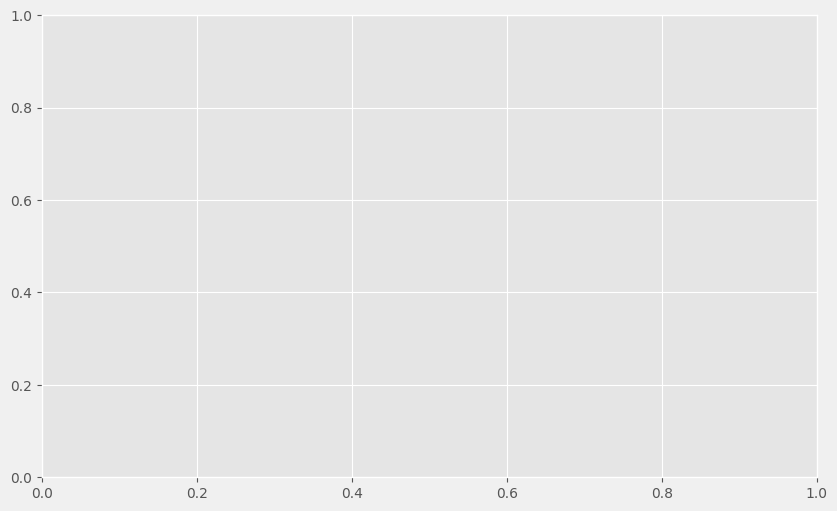

In [47]:
plt.style.use('ggplot')


fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor("#F0F0F0")

# Plotting plan level 0 and plan level 3 rows 
plt.plot(pl_month_df['month'][0:8], pl_month_df['searchCount'][0:8], marker='o', linestyle='-')
plt.plot(pl_month_df['month'][8:], pl_month_df['searchCount'][8:], marker='o', linestyle='-')

plt.title('Average Search Volume Per Hour', 
             fontsize = 12, fontweight = 'bold', x= .45, y = 1.03)

plt.legend(labels = ['planLevel 0', 'planLevel 3'])

ax.set_xlabel('Month')
ax.set_ylabel('Quantity of Searches')
# plt.xticks(range(0, 24))


plt.show()

## What differences would you highlight between the trends in search for plan levels?

### Average max price by plan level - On average Plan level 0 searches are more than double the max price of plan level 3 searches

In [37]:
query = '''SELECT planLevel,
                AVG(maxPrice) as averagePrice
           FROM athletes
           GROUP BY planLevel
        '''
avg_price_df = pd.read_sql(query, conn)
avg_price_df.head(50)

,planLevel,averagePrice
0,0,5922.769672
1,3,2448.954545


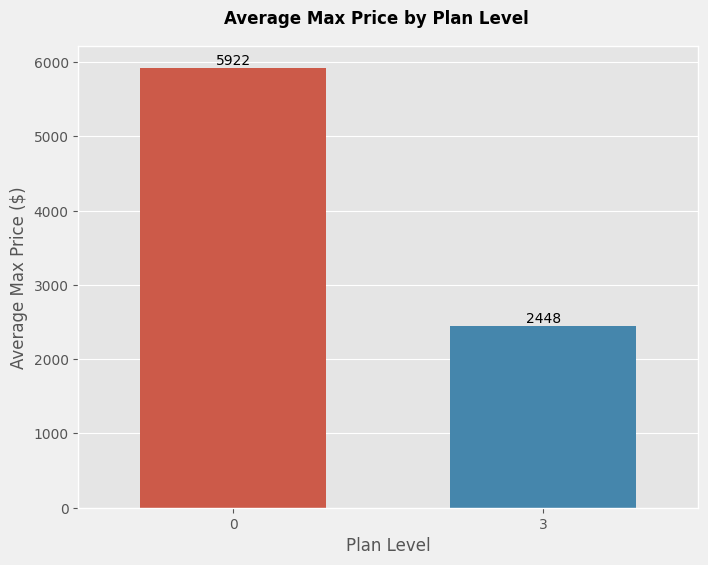

In [48]:
import seaborn as sns

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 6))
fig.set_facecolor("#F0F0F0")

# Seaborn barplot for the plan level and average price data
sns.barplot(x='planLevel', y='averagePrice', data=avg_price_df, ax=ax, width = .6)

# Adding in annotations for bar counts 
for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=10, color='black')

plt.title('Average Max Price by Plan Level', 
          fontsize=12, fontweight='bold', x=0.48, y=1.03)

ax.set_xlabel('Plan Level')
ax.set_ylabel('Average Max Price ($)')

plt.show()

### top 5 athletes searched by each plan level - This can be useful in determining what athletes to reccomend to what plan level users. Of course with a limited amount of data it is difficult to make a determination.

In [39]:
query = '''SELECT athlete_name_y,
                planLevel,
                COUNT(athlete_name_y) AS searchCount
           FROM athletes 
           WHERE athlete_name_y IS NOT NULL
           GROUP BY athlete_name_y, planLevel
           ORDER BY searchCount DESC
        '''
top_5_df = pd.read_sql(query, conn)
top_5_df.head(10)

,athlete_name_y,planLevel,searchCount
0,Fernanda Mackenna,3,16
1,Klay Thompson,0,16
2,Taylor Red,0,15
3,Jimmy Rollins,0,14
4,Valeriya Kosmachuk,0,14
5,Timothy Saipramuk,0,13
6,Jack Wilshere,3,11
7,Karim Benzema,0,11
8,Andre Gomes,0,10
9,CJ Perry,0,10


In [40]:
top_5_df = top_5_df.groupby('planLevel').apply(lambda x: x.nlargest(5, 'searchCount')).reset_index(drop=True)
top_5_df.shape

(10, 3)

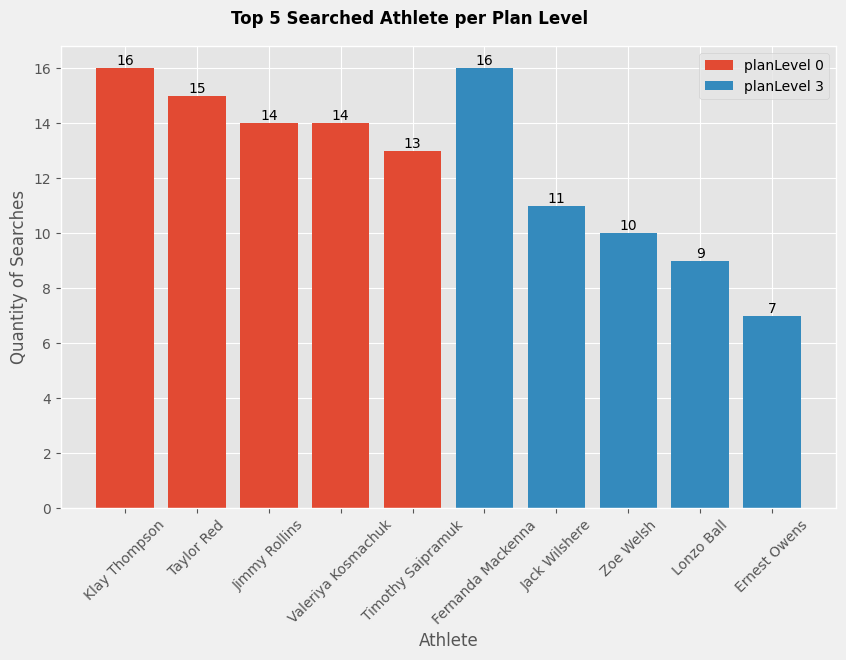

In [49]:
plt.style.use('ggplot')


fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor("#F0F0F0")

# Plotting each athlete search count in each plan level
for category, group in top_5_df.groupby('planLevel'):
    plt.bar(group['athlete_name_y'], group['searchCount'], label=f'Category {category}')


plt.title('Top 5 Searched Athlete per Plan Level', 
             fontsize = 12, fontweight = 'bold', x= .45, y = 1.03)


ax.set_xlabel('Athlete')
ax.set_ylabel('Quantity of Searches')
plt.legend(labels = ['planLevel 0', 'planLevel 3'])

# Adding in annotations for bar counts
for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=10, color='black')

plt.xticks(rotation=45)

plt.show()